In [ ]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import itertools
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
%matplotlib inline

In [ ]:
'''
# 파일 unzip

%cd //content/drive/MyDrive/Colab Notebooks/데기인/team project
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/데기인/team project/dataset.zip"
'''

/content/drive/MyDrive/Colab Notebooks/데기인/team project


# 1. 데이터 전처리

In [ ]:
def list_dataset():
    for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/dataset'):
        for filename in filenames:
            print(os.path.join(dirname, filename))


# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]


In [ ]:
IMAGES_DIR = '/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/dataset/'

train_file = '/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/dataset/one-indexed-files-notrash_train.txt'
val_file   = '/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/dataset/one-indexed-files-notrash_val.txt'
test_file  = '/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/dataset/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(test_file,   sep=' ', header=None, names=['rel_path', 'label'])

df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 431 samples.


In [ ]:
df_test.head()

,rel_path,label
0,paper/paper70.jpg,paper
1,paper/paper380.jpg,paper
2,cardboard/cardboard31.jpg,cardboard
3,glass/glass12.jpg,glass
4,paper/paper169.jpg,paper


In [ ]:
datagen = ImageDataGenerator()

datagen_train = ImageDataGenerator(

    ###  Augmentation Start  ###

    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2

    ##  Augmentation End  ###
)

datagen_train = datagen_train.flow_from_dataframe(
    target_size=(224,224),
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    rescale=1/255.,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_valid = datagen.flow_from_dataframe(
    target_size=(224,224),
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    rescale=1/255.,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

test_generator = datagen.flow_from_dataframe(
    target_size=(224,224),
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    rescale=1./255,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=7
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 431 validated image filenames belonging to 6 classes.


In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 주석

In [ ]:
'''
import numpy as np

# 훈련 데이터
train_images = []
train_labels = []
for _ in range(len(datagen_train)):
    batch_images, batch_labels = datagen_train.next()
    train_images.append(batch_images)
    train_labels.append(batch_labels)

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

# 검증 데이터
valid_images = []
valid_labels = []
for _ in range(len(datagen_valid)):
    batch_images, batch_labels = datagen_valid.next()
    valid_images.append(batch_images)
    valid_labels.append(batch_labels)

valid_images = np.concatenate(valid_images)
valid_labels = np.concatenate(valid_labels)

# 테스트 데이터
test_images = []
test_labels = []
for _ in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    test_images.append(batch_images)
    test_labels.append(batch_labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
'''

In [ ]:
'''
d = pd.DataFrame(train_labels, columns=['1','2','3','4','5','6'])

d['label']=''
i=0
n1=d.shape[0]
n2=d.shape[1]

while (i<n1) :
  j=0
  while (j<n2) :
    if (d.iloc[i,j]==1) :
      d.iloc[i,6]=d.columns[j]
      break
    j+=1
  i+=1

Y_train=d['label'].values
Y_train.shape
'''

(1768,)

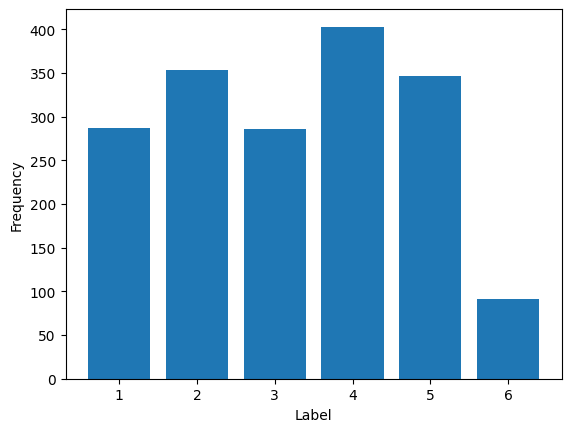

In [ ]:
'''
import numpy as np
import matplotlib.pyplot as plt

# 값의 빈도 체크
Y_train = Y_train.astype(int)
value_counts = np.bincount(Y_train)

# 막대 그래프 그리기
indices = np.nonzero(value_counts)[0]
plt.bar(indices, value_counts[indices])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

#train set의 불균형을 보여줌
'''

In [ ]:
'''
X_train = train_images
X_valid = valid_images
X_test = test_images

Y_train = train_labels
Y_valid = valid_labels
Y_test = test_labels

print('X_train shape: %s'%str(X_train.shape))
print('X_valid shape: %s'%str(X_valid.shape))
print('X_test shape: %s'%str(X_test.shape))

print('Y_train shape: %s'%str(Y_train.shape))
print('Y_valid shape: %s'%str(Y_valid.shape))
print('Y_test shape: %s'%str(Y_test.shape))
'''

X_train shape: (1768, 224, 224, 3)
X_valid shape: (328, 224, 224, 3)
X_test shape: (431, 224, 224, 3)
Y_train shape: (1768, 6)
Y_valid shape: (328, 6)
Y_test shape: (431, 6)


In [ ]:
'''
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0
'''

# 2. cnn + XGboost

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [ ]:
model = Sequential()
# input: 28x28 images with 1 channels -> (28, 28, 1) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3),padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())



#model = keras.applications.inception_v3.InceptionV3(weights= None, include_top=False, input_shape= (28,28,1))
model.add(Dense(256, activation='relu', name='my_dense'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 224, 224, 32)      0

In [ ]:
from keras.models import Model
layer_name='my_dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                             

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath = "/content/gdrive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/checkpoint/best_cnn_1.ckpt"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,             #모수값만 저장
    mode='auto',                             #min , auto로 해도 됨
    monitor='val_accuracy',
    save_best_only=True,                  #최적값만 저장
    verbose=1)                               #얼마나 자세히? 적당히1

In [ ]:
# Train the model.
history = model.fit_generator(generator=datagen_train,
          validation_data=datagen_valid,
          epochs=100,                                         #기본 100~200
          verbose=1,
          callbacks=[model_checkpoint_callback]
)

<ipython-input-18-e75291d32a74>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=datagen_train,


Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 1.6353 - accuracy: 0.3394 
Epoch 1: val_accuracy improved from -inf to 0.19817, saving model to /content/gdrive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/checkpoint/best_cnn_1.ckpt
56/56 [==============================] - 1326s 23s/step - loss: 1.6353 - accuracy: 0.3394 - val_loss: 1.7784 - val_accuracy: 0.1982
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 1.5013 - accuracy: 0.3999
Epoch 2: val_accuracy improved from 0.19817 to 0.34146, saving model to /content/gdrive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/checkpoint/best_cnn_1.ckpt
56/56 [==============================] - 33s 595ms/step - loss: 1.5013 - accuracy: 0.3999 - val_loss: 1.6652 - val_accuracy: 0.3415
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 1.4164 - accuracy: 0.4197
Epoch 3: val_accuracy improved from 0.34146 to 0.42378, saving model to /content/gdrive/M

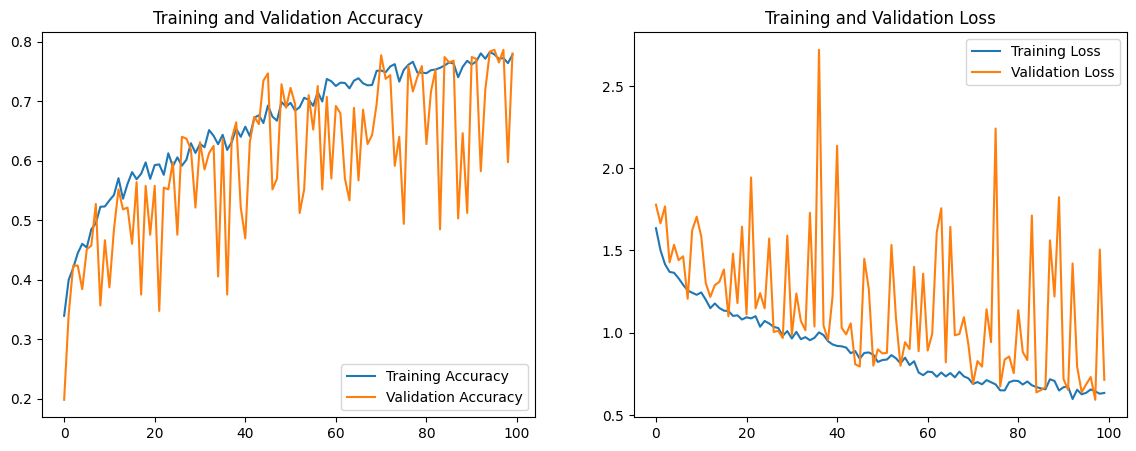

In [ ]:
# accuracy, loss 그래프

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# 최적의 성능을 갖는 모형 로드하기
# 불러온 모형의 성능 확인
model.load_weights(checkpoint_filepath)
score=model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

431/431 [==============================] - 286s 663ms/step - loss: 0.7461 - accuracy: 0.7471
Test loss: 0.7460720539093018
Test accuracy: 0.747099757194519


431/431 [==============================] - 4s 8ms/step
Classification Report
              precision    recall  f1-score   support

   cardboard       0.86      0.86      0.86        70
       glass       0.75      0.74      0.75        82
       metal       0.81      0.62      0.70        68
       paper       0.66      0.91      0.76       108
     plastic       0.75      0.58      0.66        74
       trash       0.82      0.62      0.71        29

    accuracy                           0.75       431
   macro avg       0.77      0.72      0.74       431
weighted avg       0.76      0.75      0.74       431



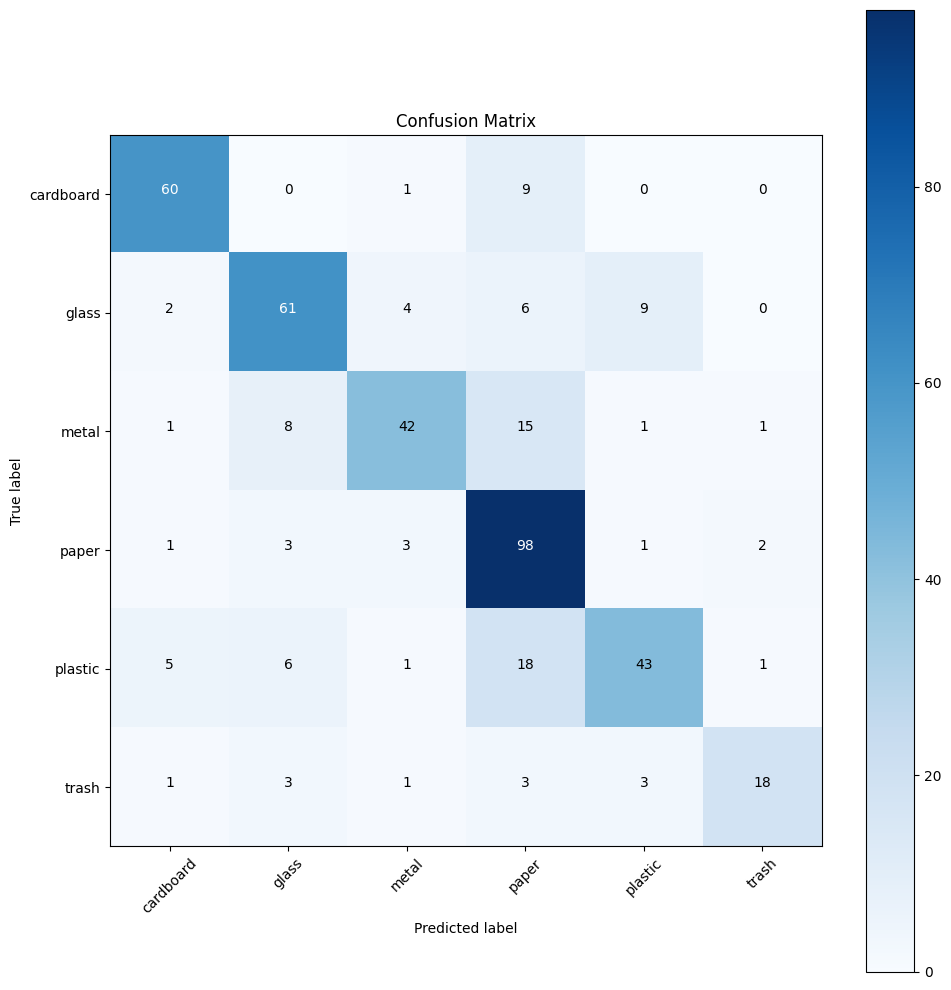

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
intermediate_output = intermediate_layer_model.predict(datagen_train)
X_train = pd.DataFrame(data=intermediate_output)

56/56 [==============================] - 26s 466ms/step


In [ ]:
intermediate_output = intermediate_layer_model.predict(datagen_valid)
X_valid = pd.DataFrame(data=intermediate_output)

11/11 [==============================] - 1s 133ms/step


In [ ]:
intermediate_output = intermediate_layer_model.predict(test_generator)
X_test = pd.DataFrame(data=intermediate_output)

431/431 [==============================] - 3s 7ms/step


In [ ]:
from xgboost import XGBClassifier

xgbmodel = XGBClassifier(objective = "multi:softmax", n_estimators=100, n_jobs=-1, learning_rate=0.5, max_depth= 5, min_child_weight= 1, seed=0)
xgbmodel.fit(X_train, datagen_train.classes)
xgbmodel.score(X_valid, datagen_valid.classes)

0.19207317073170732

In [ ]:
pred_xgb = xgbmodel.predict(X_test)

Classification Report
              precision    recall  f1-score   support

   cardboard       0.11      0.10      0.10        70
       glass       0.13      0.15      0.14        82
       metal       0.09      0.07      0.08        68
       paper       0.27      0.31      0.29       108
     plastic       0.16      0.19      0.17        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.17       431
   macro avg       0.13      0.14      0.13       431
weighted avg       0.15      0.17      0.16       431



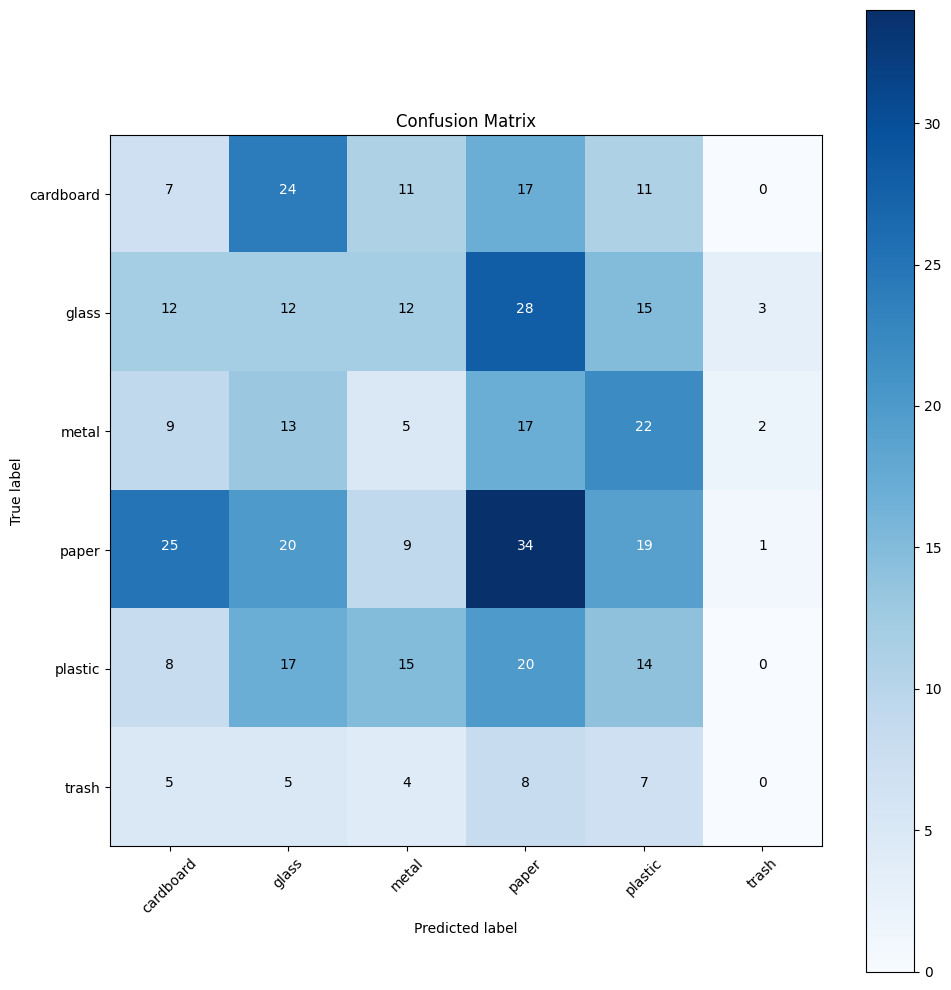

In [ ]:
target_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_xgb)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, pred_xgb, target_names=target_names))

In [ ]:
count = 0
for i in range(len(pred_xgb)) :
    if pred_xgb[i] == test_generator.classes[i] :
        count += 1

print("accuracy :", count / len(pred_xgb) * 100)

accuracy : 16.70533642691415


# 3. densenet201 + XGboost

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers import LeakyReLU

In [ ]:
# DenseNet201 모델 불러오기
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 중간 레이어 생성
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', name='my_dense')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
preds = tf.keras.layers.Dense(6, activation='softmax')(x)

# 모델 생성
densenet201 = tf.keras.Model(inputs=base_model.input, outputs=preds)

74836368/74836368 [==============================] - 5s 0us/step


In [ ]:
# Compile the model
densenet201.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
densenet201.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
from keras.models import Model
layer_name='my_dense'
intermediate_layer_model = Model(inputs=densenet201.input,
                                 outputs=densenet201.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/checkpoint/best_densenet+Xgboost_cnn.ckpt"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,             #모수값만 저장
    monitor='val_accuracy',
    mode='auto',                             #min , auto로 해도 됨
    save_best_only=True,                  #최적값만 저장
    verbose=1)                               #얼마나 자세히? 적당히1

In [ ]:
# Train the model.
history = densenet201.fit_generator(generator=datagen_train,
          validation_data=datagen_valid,
          epochs=100,                                         #기본 100~200
          verbose=1,
          callbacks=[model_checkpoint_callback]
)

<ipython-input-35-3294f0c5f425>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = densenet201.fit_generator(generator=datagen_train,


Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 1.2583 - accuracy: 0.5594
Epoch 1: val_accuracy improved from -inf to 0.27134, saving model to /content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/checkpoint/best_densenet+Xgboost_cnn.ckpt
56/56 [==============================] - 187s 963ms/step - loss: 1.2583 - accuracy: 0.5594 - val_loss: 10.5191 - val_accuracy: 0.2713
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.9828 - accuracy: 0.6374
Epoch 2: val_accuracy improved from 0.27134 to 0.41159, saving model to /content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/checkpoint/best_densenet+Xgboost_cnn.ckpt
56/56 [==============================] - 43s 754ms/step - loss: 0.9828 - accuracy: 0.6374 - val_loss: 3.7562 - val_accuracy: 0.4116
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.9110 - accuracy: 0.6725
Epoch 3: val_accuracy did not improve from 0.41159
56/56 [==

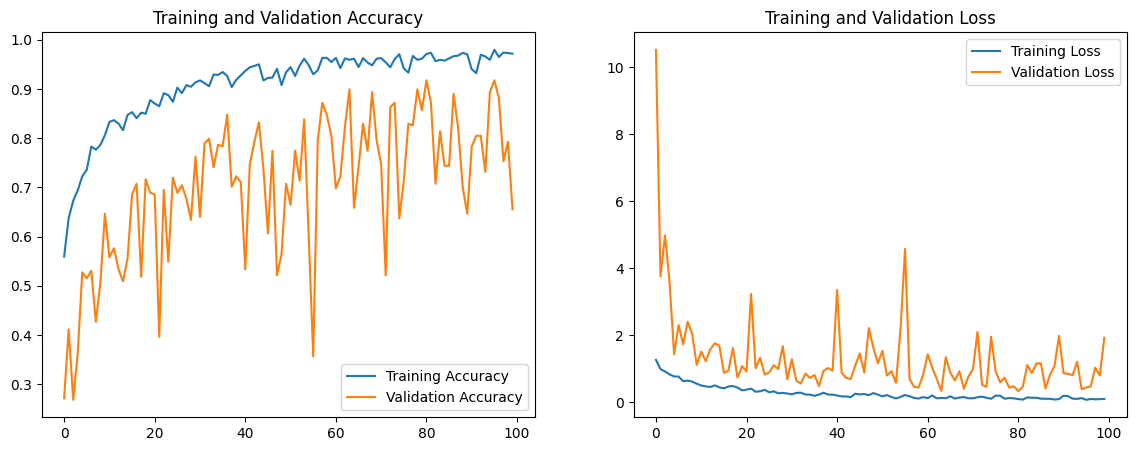

In [ ]:
# accuracy, loss 그래프

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# 최적의 성능을 갖는 모형 로드하기
# 불러온 모형의 성능 확인
densenet201.load_weights(checkpoint_filepath)
score=densenet201.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

431/431 [==============================] - 12s 24ms/step - loss: 0.5369 - accuracy: 0.8817
Test loss: 0.536908745765686
Test accuracy: 0.8816705346107483


431/431 [==============================] - 12s 20ms/step
Classification Report
              precision    recall  f1-score   support

   cardboard       0.97      0.90      0.93        70
       glass       0.93      0.85      0.89        82
       metal       0.83      0.91      0.87        68
       paper       0.84      0.95      0.90       108
     plastic       0.89      0.86      0.88        74
       trash       0.82      0.62      0.71        29

    accuracy                           0.88       431
   macro avg       0.88      0.85      0.86       431
weighted avg       0.88      0.88      0.88       431



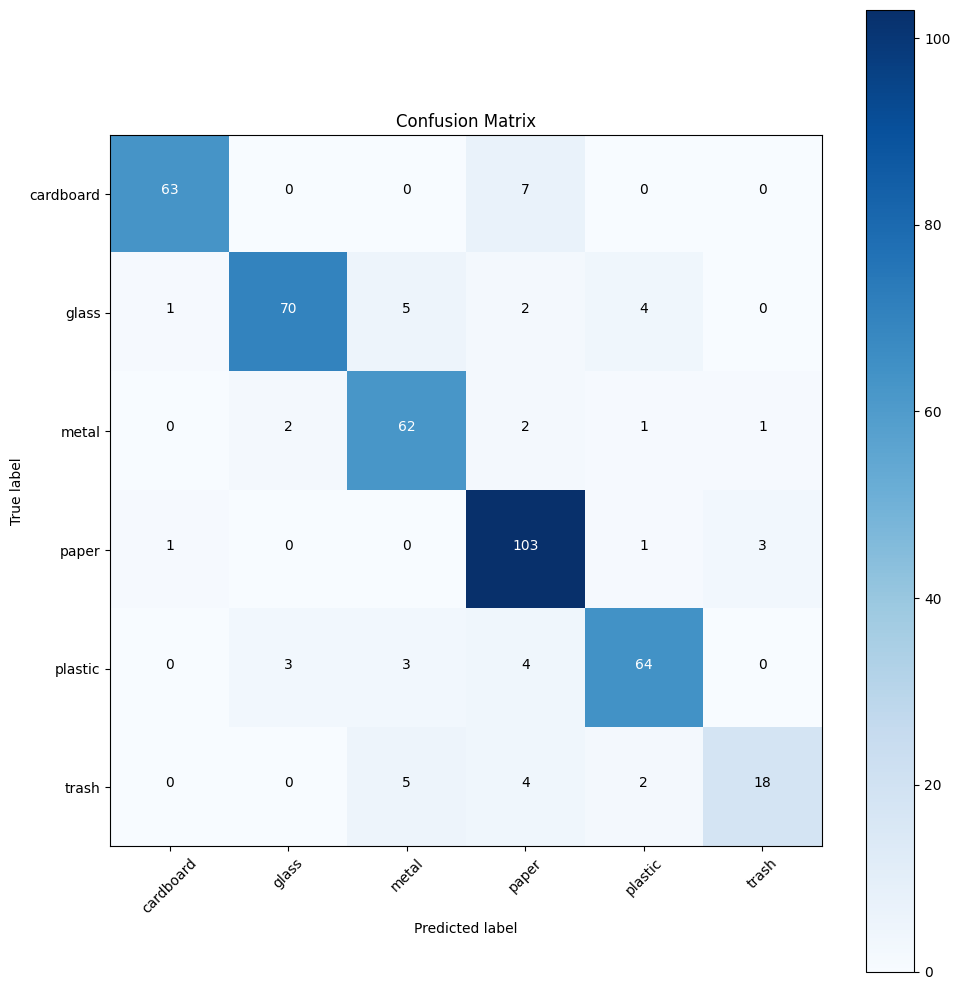

In [ ]:
Y_pred = densenet201.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
intermediate_output = intermediate_layer_model.predict(datagen_train)
X_train = pd.DataFrame(data=intermediate_output)

56/56 [==============================] - 30s 476ms/step


In [ ]:
intermediate_output = intermediate_layer_model.predict(datagen_valid)
X_valid = pd.DataFrame(data=intermediate_output)

11/11 [==============================] - 2s 150ms/step


In [ ]:
intermediate_output = intermediate_layer_model.predict(test_generator)
X_test = pd.DataFrame(data=intermediate_output)

431/431 [==============================] - 9s 21ms/step


In [ ]:
from xgboost import XGBClassifier

xgbmodel = XGBClassifier(objective = "multi:softmax", n_estimators=100, n_jobs=-1, learning_rate=0.5, max_depth= 5, min_child_weight= 1, seed=0)
xgbmodel.fit(X_train, datagen_train.classes)
xgbmodel.score(X_valid, datagen_valid.classes)

0.20426829268292682

In [ ]:
pred_xgb = xgbmodel.predict(X_test)

Classification Report
              precision    recall  f1-score   support

   cardboard       0.21      0.16      0.18        70
       glass       0.18      0.22      0.20        82
       metal       0.12      0.09      0.10        68
       paper       0.33      0.41      0.36       108
     plastic       0.20      0.24      0.22        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.23       431
   macro avg       0.17      0.19      0.18       431
weighted avg       0.20      0.23      0.21       431



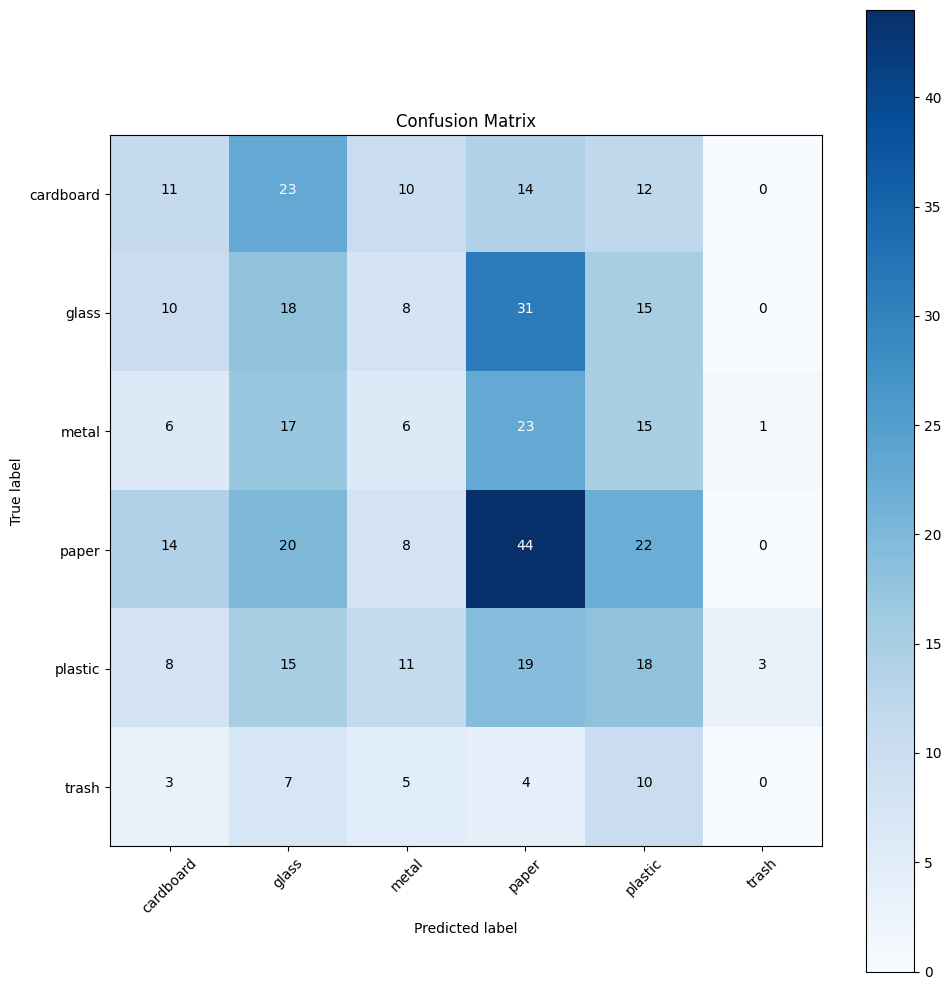

In [ ]:
target_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, pred_xgb)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, pred_xgb, target_names=target_names))

In [ ]:
count = 0
for i in range(len(pred_xgb)) :
    if pred_xgb[i] == test_generator.classes[i] :
        count += 1

print("accuracy :", count / len(pred_xgb) * 100)

accuracy : 22.505800464037122
